<a href="https://colab.research.google.com/github/efandresena/large-scale-movie-recommendation/blob/main/mirindraf_mlas_practical_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Base Data Structure

In [1]:
import numpy as np
from numba import njit
from ast import List
import random
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt

## 1 Definition

In [2]:
class CompactDatasetCSR:
    """
    CSR (Compressed Sparse Row) format optimized for Numba.
    Stores ratings as separate parallel arrays instead of structured arrays.
    """

    def __init__(self, shared_index=None):
        """
        Args:
            shared_index: Optional tuple of shared index mappings from another dataset
                         Format: (userId_to_idx, idx_to_userId, movieId_to_idx, idx_to_movieId)
        """
        if shared_index is not None:
            # Share index with another dataset (for train/test split)
            self.userId_to_idx, self.idx_to_userId, self.movieId_to_idx, self.idx_to_movieId = shared_index
            self._owns_index = False
        else:
            # Create new index
            self.userId_to_idx = {}
            self.idx_to_userId = []
            self.movieId_to_idx = {}
            self.idx_to_movieId = []
            self._owns_index = True



        # Temporary storage for ratings before finalization
        self._temp_ratings = []  # Store as list of (user_idx, movie_idx, rating)

        # CSR format for user ratings (row-based)
        self.user_indptr = None      # Pointer to start of each user's ratings
        self.user_movie_ids = None   # Flat array of movie indices
        self.user_ratings = None     # Flat array of ratings

        # CSR format for movie ratings (column-based)
        self.movie_indptr = None     # Pointer to start of each movie's ratings
        self.movie_user_ids = None   # Flat array of user indices
        self.movie_ratings = None    # Flat array of ratings

        self._finalized = False

    @property
    def usr_size(self):
        return len(self.idx_to_userId)

    @property
    def movie_size(self):
        return len(self.idx_to_movieId)

    def get_shared_index(self):
        """Return index mappings to share with another dataset."""
        return (self.userId_to_idx, self.idx_to_userId,
                self.movieId_to_idx, self.idx_to_movieId)

    def add_rating(self, userId, movieId, rating_value):
        """Add a rating entry to the dataset."""
        if self._finalized:
            raise RuntimeError("Cannot add ratings after finalization")

        # Index user (only if we own the index)
        if self._owns_index:
            if userId not in self.userId_to_idx:
                user_pos = len(self.idx_to_userId)
                self.userId_to_idx[userId] = user_pos
                self.idx_to_userId.append(userId)

        # Index movie (only if we own the index)
        if self._owns_index:
            if movieId not in self.movieId_to_idx:
                movie_pos = len(self.idx_to_movieId)
                self.movieId_to_idx[movieId] = movie_pos
                self.idx_to_movieId.append(movieId)

        # Get indices
        user_pos = self.userId_to_idx.get(userId)
        movie_pos = self.movieId_to_idx.get(movieId)

        # Only add if both user and movie exist in index here pos mean the list index row and colum
        if user_pos is not None and movie_pos is not None:
            self._temp_ratings.append((user_pos, movie_pos, rating_value))


    def finalize(self):
        """Convert to CSR format for Numba optimization."""
        if self._finalized:
            return

        print(f"Finalizing dataset to CSR format... ({len(self._temp_ratings)} ratings)")

        M = self.usr_size
        N = self.movie_size


        # Sort ratings by user, then by movie (for CSR user format)
        print("  Sorting by user...")
        self._temp_ratings.sort(key=lambda x: (x[0], x[1]))


        # Build user CSR arrays
        print("  Building user CSR arrays...")
        self.user_indptr = np.zeros(M + 1, dtype=np.int64)
        self.user_movie_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.user_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_user = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            # Update indptr for new users
            while current_user < user_idx:
                current_user += 1
                self.user_indptr[current_user] = idx

            self.user_movie_ids[idx] = movie_idx
            self.user_ratings[idx] = rating

        # Fill remaining indptr
        while current_user < M:
            current_user += 1
            self.user_indptr[current_user] = len(self._temp_ratings)


        # Sort ratings by movie, then by user (for CSR movie format)
        print("  Sorting by movie...")
        self._temp_ratings.sort(key=lambda x: (x[1], x[0]))

        # Build movie CSR arrays
        print("  Building movie CSR arrays...")
        self.movie_indptr = np.zeros(N + 1, dtype=np.int64)
        self.movie_user_ids = np.zeros(len(self._temp_ratings), dtype=np.int32)
        self.movie_ratings = np.zeros(len(self._temp_ratings), dtype=np.float32)

        current_movie = -1
        for idx, (user_idx, movie_idx, rating) in enumerate(self._temp_ratings):
            # Update indptr for new movies
            while current_movie < movie_idx:
                current_movie += 1
                self.movie_indptr[current_movie] = idx

            self.movie_user_ids[idx] = user_idx
            self.movie_ratings[idx] = rating

        # Fill remaining indptr
        while current_movie < N:
            current_movie += 1
            self.movie_indptr[current_movie] = len(self._temp_ratings)

        # Free temporary memory
        self._temp_ratings = None

        self._finalized = True
        print(f"✓ Finalized: {self}")

    def __repr__(self):
        if self._finalized:
            total = len(self.user_ratings) if self.user_ratings is not None else 0
        else:
            total = len(self._temp_ratings)
        return f"CompactDatasetCSR(users={self.usr_size}, movies={self.movie_size}, ratings={total})"




## 2 Helper function :


In [3]:
# Index to Id and Id to Index for movie

def index_to_movie_Id(dataset: CompactDatasetCSR, indexes:List):
  ids = []
  for idx in indexes:
    id = dataset.idx_to_movieId[idx]
    ids.append(id)
  return ids

def movie_id_to_idx(dataset: CompactDatasetCSR, IDs:List):
  indexes = []
  for id in IDs:
    idx = dataset.movieId_to_idx[str(id)]
    indexes.append(idx)
  return indexes

###############################################################################################################33
# Loading data
def load_data(filepath, test_ratio=0.2, seed=42):
    """
    Load dataset  train/test split that maintains shared indices.
    If only want to load the dataset set test_ratio = 0
    CRITICAL: Train and test must share the same user/movie index mappings!
    """
    random.seed(seed)

    # Step 1: Create TRAIN dataset first
    print("=" * 60)
    print("STEP 1: Loading TRAIN dataset (building index)...")
    print("=" * 60)
    train = CompactDatasetCSR()  # Owns the index

    # Step 2: Create TEST dataset sharing train's index
    print("\nSTEP 2: Creating TEST dataset (sharing train's index)...")
    test = CompactDatasetCSR(shared_index=train.get_shared_index())

    # Step 3: Load data and split
    print("\nSTEP 3: Loading data from CSV...")
    train_count = 0
    test_count = 0

    with open(filepath, 'r') as file:
        next(file)  # Skip header

        for i, line in enumerate(file):
            if i % 1_000_000 == 0 and i > 0:
                print(f"  Processed {i//1_000_000}M lines... "
                      f"(train: {train_count:,}, test: {test_count:,})")

            userId, movieId, rating, _ = line.strip().split(',')
            rating = float(rating)

            # Random split with consistent ratio
            if random.random() < test_ratio:
                test.add_rating(userId, movieId, rating)
                test_count += 1
            else:
                train.add_rating(userId, movieId, rating)
                train_count += 1

    print(f"\n✓ Loaded {train_count:,} train ratings, {test_count:,} test ratings")
    print(f"  Users: {train.usr_size:,}, Movies: {train.movie_size:,}")

    # Step 4: Finalize both datasets
    print("\nSTEP 4: Finalizing datasets...")
    train.finalize()
    test.finalize()

    print("\n" + "=" * 60)
    print("DATASET READY!")
    print("=" * 60)
    print(f"Train: {train}")
    print(f"Test:  {test}")
    print("=" * 60 + "\n")

    return train, test

# Filtering
def check_if_less_rating(train: CompactDatasetCSR,  bests):
  idx_to_remove = []
  # count the number of rating an index has
  c = 0
  limit = 500
  for idx in bests:
    m = idx
    start = train.movie_indptr[m]
    end = train.movie_indptr[m + 1]
    if end-start<=limit:
      idx_to_remove.append(idx)
      c+=1
  print(f"{c} movies having number of ratings less than {limit}.")
  return idx_to_remove

  ## Printing

def pretty_print_recommendations(func):
    def wrapper(pd_movies, ID):
        print("\n" + "="*50)
        print("                 MOVIE RECOMMENDATION")
        print("="*50 + "\n")
        func(pd_movies, ID)
        print("\n" + "="*50)
    return wrapper


@pretty_print_recommendations
def get_movie_info(pd_movies, ID):
    for idx, movie_id in enumerate(ID, start=1):

        row = pd_movies.loc[pd_movies['movieId'] == int(movie_id)].iloc[0]

        # Tag for top 3 recommendations
        tag = " 🔥 MUST WATCH!" if idx <= 3 else ""

        print(f"{idx}. {row['title']}{tag}")
        print(f"   Genres: {row['genres']}\n")

## Emmbedings plot in 2D k =2

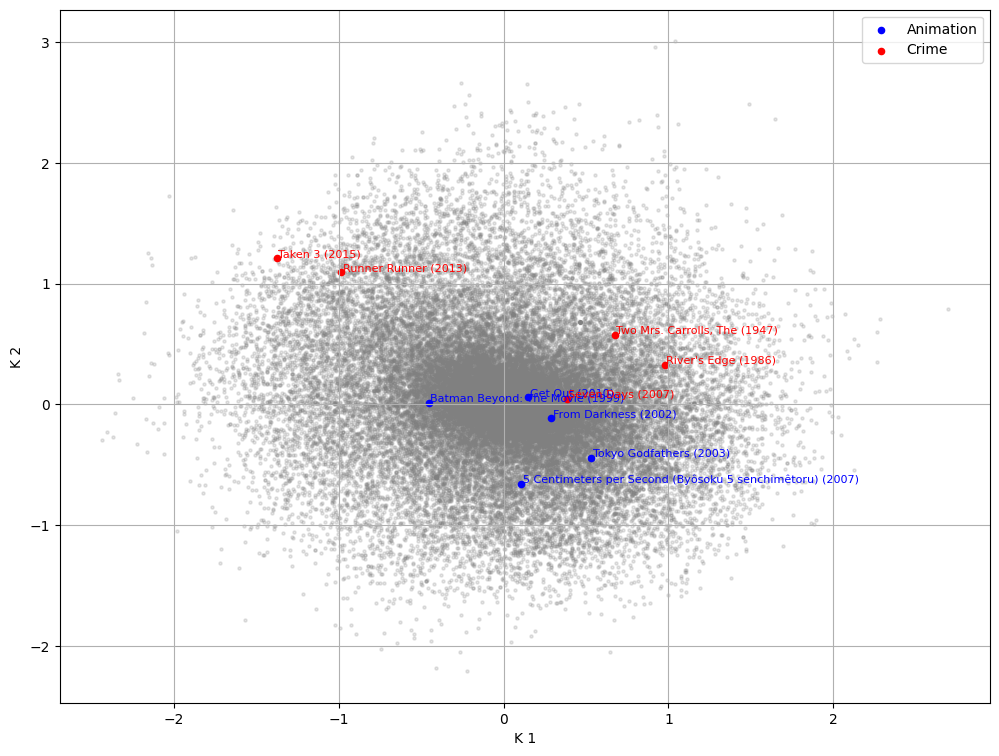

In [4]:

# --- 1. Load embeddings ---
with open('/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings/embeddings2.pkl', 'rb') as f:
    embeddings_data = pickle.load(f)
    v = embeddings_data[3] # index 3 = movie embeddings

# --- 2. Load test object to get movieId mapping ---
with open('/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings/model_run_params.pkl', 'rb') as f:
    params = pickle.load(f)
test = params['test']


# --- 3. Load movies.csv ---
movies = pd.read_csv('/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings/movies.csv')

# --- Convert movie IDs to int for merging ---
movies['movieId'] = movies['movieId'].astype(int)
movie_ids = np.array(test.idx_to_movieId).astype(int)

# --- Build DataFrame linking embeddings to movies ---
df = pd.DataFrame({
    'movie_idx': np.arange(v.shape[0]),
    'movieId': movie_ids,
    'x': v[:, 0],
    'y': v[:, 1]
}).merge(movies, on='movieId')

# --- Filter movies by genre ---
animation_movies = df[df['genres'].str.contains('Animation', case=False)]
crime_movies     = df[df['genres'].str.contains('Crime', case=False)]

# --- Optionally pick a few from each ---
animation_sel = animation_movies.sample(5, random_state=0)
crime_sel     = crime_movies.sample(5, random_state=0)

# --- Plot all movies lightly in gray ---
plt.figure(figsize=(12, 9))
plt.scatter(df["x"], df["y"], s=5, alpha=0.2, color="gray")

# --- Plot selected movies ---
plt.scatter(animation_sel["x"], animation_sel["y"], s=20, color="blue", label="Animation")
plt.scatter(crime_sel["x"], crime_sel["y"], s=20, color="red", label="Crime")

# --- Annotate ---
for _, row in animation_sel.iterrows():
    plt.text(row["x"] + 0.01, row["y"] + 0.01, row["title"], fontsize=8, color="blue")
for _, row in crime_sel.iterrows():
    plt.text(row["x"] + 0.01, row["y"] + 0.01, row["title"], fontsize=8, color="red")

plt.xlabel("K 1")
plt.ylabel("K 2")
#plt.title("2D Movie Embeddings: Animation vs Crime")
plt.legend()
plt.grid(True)
plt.savefig('2D Movie Embeddings: Animation vs Crime.pdf')
plt.show()

# B. Prediction to new dummy user based on data from step 3

## 1 Class New Dummy User with its movies and ratings

In [5]:

class DummyUser:
    def __init__(self, rated_movies, k ):
        """
        num_movies: total number of movies
        rated_movies: list of tuples (movie_idx, rating) # here we have the movie idx
        k: latent dimension
        """
        self.k = k

        # Ratings
        self.movie_idx = [movie_idx for movie_idx, _ in rated_movies]
        self.ratings = {movie_idx: rating for movie_idx, rating in rated_movies}

        # Latent vector and bias
        norm_k = 1/np.sqrt(self.k)
        self.u = norm_k*np.random.normal(scale=0.1, size=(1,k)).astype(np.float32)
        self.bias = 0.0

    def score_for_item(self):
        """Predict ratings the user will give to all the movies embedding .
          Output: """
        scores = self.u.dot(self.v.T) + 0.05 * self.item_biases # regularize the term bias
        return scores

    def update(self, v, item_biases, lamda=0.1, gamma=0.1):
        """
        movie_factors: array of shape (N, k)
        item_biases: array of shape (N,) vector
        """
        k = self.k
        self.v = v
        self.item_biases = item_biases
        # get the number of movie the dummy user rated:
        omega = len(self.movie_idx)
        if omega == 0:
            return
        # update bias
        numerator = 0.0
        for m_idx in self.movie_idx:
            r = self.ratings[m_idx]
            uv = (self.u @ v[m_idx]).item()
            numerator += r - item_biases[m_idx] - uv
        self.bias = lamda * numerator / (lamda * omega + gamma)

        # update latent vector

        A = np.zeros((k, k), dtype=np.float32)
        b = np.zeros(k, dtype=np.float32)
        for m_idx in self.movie_idx:
            r = self.ratings[m_idx]
            v_m = v[m_idx]
            A += np.outer(v_m, v_m)
            residual = r - self.bias - item_biases[m_idx]
            b += v_m * residual

        A = lamda * A + gamma * np.eye(k, dtype=np.float32)
        b = lamda * b
        self.u = np.linalg.solve(A, b)[None, :]



## 2 Creating an instance of new user to predict :

### Load the saved model from the last training with the same hyperparameters

In [6]:

# Define the target directory and filename where the embeddings were saved
target_directory = '/content/drive/MyDrive/BLOC#3/ML_at_Large_Scale/2dembeddings'

# EMBEDDINGS
filename = 'embeddings15k.pkl'
file_path = os.path.join(target_directory, filename)

# Load the embeddings2 from the pickle file
with open(file_path, 'rb') as f:
    loaded_embeddings2 = pickle.load(f)

# Unpack the elements
ub, mb, u, v, (
    loaded_loss_trains, loaded_loss_test, loaded_rmse_trains, loaded_rmse_tests
) = loaded_embeddings2

#PARAMETERS
filename = 'model_run_params15k.pkl'
file_path = os.path.join(target_directory, filename)

#Load the dict containingn the params
with open(file_path, 'rb') as f:
    loaded_params2 = pickle.load(f)

# Unpack the elements
train = loaded_params2['train']
test = loaded_params2['test']
k = loaded_params2['k']
lamda = loaded_params2['lamda']
gamma = loaded_params2['gamma']


### Check for polarizing movies

In [7]:
# Load the data of csv
movies = pd.read_csv(os.path.join(target_directory, 'movies.csv'))
# looking for the polarizing movie
norms = np.linalg.norm(v, axis=1)

# Build dataframe
df = pd.DataFrame({
    "movieId": [int(id) for id in train.idx_to_movieId],
    "norm": norms
}).merge(movies, on="movieId")

# Top most polarizing movies
df.sort_values("norm", ascending=False).head(10)

,movieId,norm,title,genres
1251,2628,7.045736,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Sci-Fi
324,5378,6.947781,Star Wars: Episode II - Attack of the Clones (...,Action|Adventure|Sci-Fi|IMAX
1258,2710,6.661554,"Blair Witch Project, The (1999)",Drama|Horror|Thriller
859,288,6.579132,Natural Born Killers (1994),Action|Crime|Thriller
1081,231,6.478798,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy
199,33493,6.472744,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi
727,7153,6.368982,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
27,5952,6.243678,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
313,4993,6.182791,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
1252,2657,5.943444,"Rocky Horror Picture Show, The (1975)",Comedy|Horror|Musical|Sci-Fi


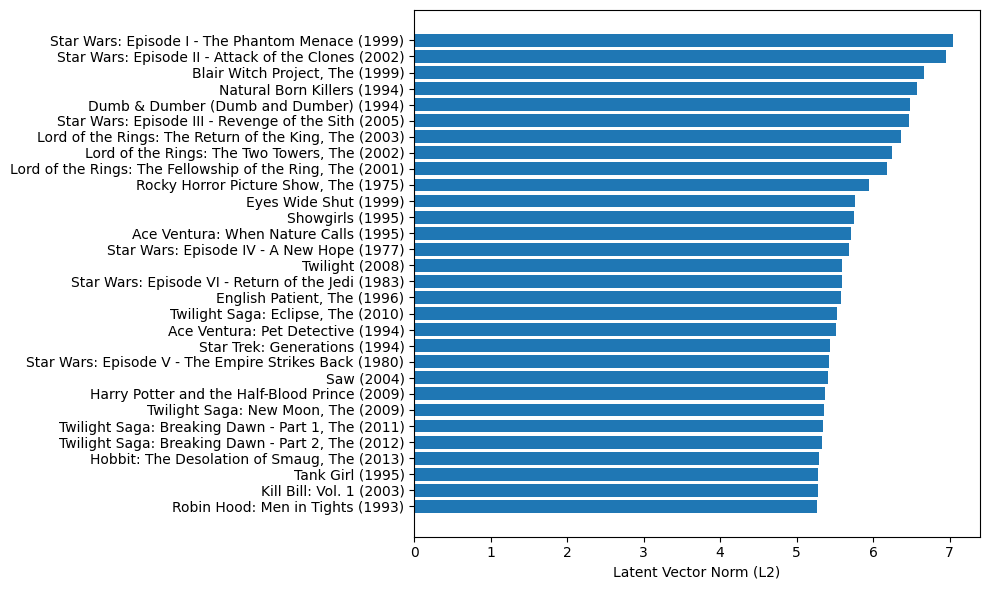

In [8]:
top_n = 30
top_polarizing = df.sort_values("norm", ascending=False).head(top_n)

# Plot
plt.figure(figsize=(10,6))
plt.barh(top_polarizing["title"], top_polarizing["norm"])
plt.xlabel("Latent Vector Norm (L2)")
#plt.ylabel("Movie Title")
#plt.title("Top Polarizing Movies (Highest Embedding Norms)")
plt.gca().invert_yaxis()   # highest at top
plt.tight_layout()
plt.savefig('Polarizing_movie.pdf')
plt.show()

### Predict function


In [9]:
def predict(user: DummyUser):
  # Embedds the new user in a latent trait vector
  user.update(v,mb,lamda,gamma)
  a = user.score_for_item()[0]

  #first ten  best possible
  sorted_idx = np.argsort(a)
  a[sorted_idx][-10:]
  best_10 = sorted_idx[-10:]

  ID = index_to_movie_Id(test, best_10)
  less_rating = check_if_less_rating(train, best_10)
  new_bests = [idx for idx in best_10 if idx not in less_rating][::-1]
  ID_new_best = index_to_movie_Id(train, new_bests)
  return ID_new_best

### Test with a kids user that like toy story :

In [10]:
idx = movie_id_to_idx(test, [1])

In [11]:
# The new user data and its embeddings
rated_movies = [(idx[0],5.0)]# list of tuples [(movies_idx, ratings)]

# Create dummy user
user = DummyUser(rated_movies, k)


In [12]:

ID_new_best = predict(user)

get_movie_info(movies, ID_new_best)

0 movies having number of ratings less than 500.

                 MOVIE RECOMMENDATION

1. Toy Story 2 (1999) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy

2. Toy Story (1995) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy

3. Toy Story 3 (2010) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy|IMAX

4. Babe (1995)
   Genres: Children|Drama

5. Monsters, Inc. (2001)
   Genres: Adventure|Animation|Children|Comedy|Fantasy

6. Wallace & Gromit: The Best of Aardman Animation (1996)
   Genres: Adventure|Animation|Comedy

7. Bug's Life, A (1998)
   Genres: Adventure|Animation|Children|Comedy

8. Iron Giant, The (1999)
   Genres: Adventure|Animation|Children|Drama|Sci-Fi

9. Wallace & Gromit: A Close Shave (1995)
   Genres: Animation|Children|Comedy

10. Finding Nemo (2003)
   Genres: Adventure|Animation|Children|Comedy




### Test with lords of the rings :

In [13]:
idx = movie_id_to_idx(test, [4993])

In [14]:
rated_movies = [(idx[0],5.0)]
# Create dummy user
user = DummyUser(rated_movies, k)

ID_new_best = predict(user)

#predict
movies = pd.read_csv(os.path.join(target_directory, 'movies.csv'))
get_movie_info(movies, ID_new_best)

0 movies having number of ratings less than 500.

                 MOVIE RECOMMENDATION

1. Lord of the Rings: The Return of the King, The (2003) 🔥 MUST WATCH!
   Genres: Action|Adventure|Drama|Fantasy

2. Lord of the Rings: The Two Towers, The (2002) 🔥 MUST WATCH!
   Genres: Adventure|Fantasy

3. Lord of the Rings: The Fellowship of the Ring, The (2001) 🔥 MUST WATCH!
   Genres: Adventure|Fantasy

4. Hobbit: An Unexpected Journey, The (2012)
   Genres: Adventure|Fantasy|IMAX

5. Hobbit: The Desolation of Smaug, The (2013)
   Genres: Adventure|Fantasy|IMAX

6. The Hobbit: The Battle of the Five Armies (2014)
   Genres: Adventure|Fantasy

7. Passion of the Christ, The (2004)
   Genres: Drama

8. Robin Hood: Men in Tights (1993)
   Genres: Comedy

9. Moulin Rouge (2001)
   Genres: Drama|Musical|Romance

10. Fountain, The (2006)
   Genres: Drama|Fantasy|Romance




# C. Test with a user with different genres taste

Horror, animation , romance and action

In [15]:
idx = movie_id_to_idx(test, [1, 3, 44, 92])

In [21]:
movies[movies['movieId'].isin([1, 3, 44, 92])][['title', 'genres']]

,title,genres
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Grumpier Old Men (1995),Comedy|Romance
43,Mortal Kombat (1995),Action|Adventure|Fantasy
90,Mary Reilly (1996),Drama|Horror|Thriller


In [16]:
rated_movies = [(idx[0],5.0),(idx[1],5.0),(idx[2],5.0),(idx[3],5.0)]
# Create dummy user
user = DummyUser(rated_movies, k)
ID_new_best = predict(user)

#predict
movies = pd.read_csv(os.path.join(target_directory, 'movies.csv'))
get_movie_info(movies, ID_new_best)

0 movies having number of ratings less than 500.

                 MOVIE RECOMMENDATION

1. Pokémon: The First Movie (1998) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Fantasy|Sci-Fi

2. Back to the Future Part III (1990) 🔥 MUST WATCH!
   Genres: Adventure|Comedy|Sci-Fi|Western

3. Space Jam (1996) 🔥 MUST WATCH!
   Genres: Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi

4. Short Circuit 2 (1988)
   Genres: Comedy|Sci-Fi

5. Back to the Future Part II (1989)
   Genres: Adventure|Comedy|Sci-Fi

6. Pokémon the Movie 2000 (2000)
   Genres: Animation|Children

7. Police Academy 5: Assignment: Miami Beach (1988)
   Genres: Comedy|Crime

8. Tank Girl (1995)
   Genres: Action|Comedy|Sci-Fi

9. Crow: City of Angels, The (1996)
   Genres: Action|Thriller

10. Judge Dredd (1995)
   Genres: Action|Crime|Sci-Fi




The model is almost sure to select or recommend movies that is the same as the one we chose to rate but if we gave different ratigns for different genre fo rmovies the model will be confused . In the next work we will work out with implementation of the features genres. So that our model will make sense of the taste of the user